Line graph: 
         EVSales
year            
2010     11194.0
2011     53010.0
2012    132061.0
2013    218615.0
2014    357700.0
2015    715780.0
2016    894175.1
2017   1438670.0
2018   2286390.0
2019   2259380.0
2020   3164620.0
2021   6754200.0
2022  10632800.0


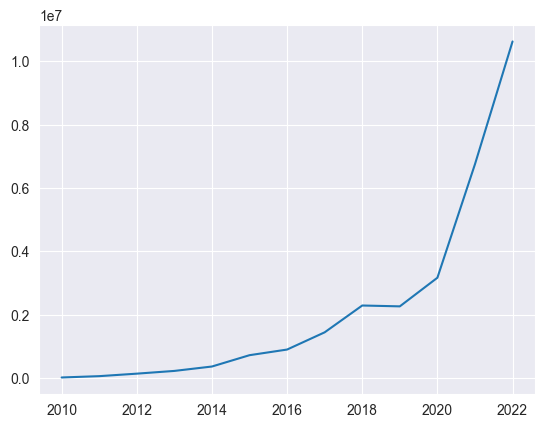

"\n\n\nplt.plot(result)       \nax.xaxis.get_data_interval()\nax.yaxis.get_data_interval()\nax.margins(0.05)\n#plt.tight_layout()\nplt.show() \n\n\nx = np.array([0,1,2,3])\ny = np.array([0.650, 0.660, 0.675, 0.685])\nmy_xticks = ['a', 'b', 'c', 'd']\nplt.xticks(x, my_xticks)\nplt.yticks(np.arange(y.min(), y.max(), 0.005))\nplt.plot(x, y)\nplt.grid(axis='y', linestyle='-')\n"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("IEA Global EV Data 2023.csv")


result = df.loc[(df['region'] == 'World') & (df['category'] == 'Historical') & (df['parameter'] == 'EV sales')].groupby(["year"]).agg(EVSales=('value', 'sum'))


# plotting a line graph 
print("Line graph: ") 
print(result)
#plt.plot(result["year"], result["EVSales"]) 
fig, ax = plt.subplots()
ax.plot(result)

#print(ax.xaxis.get_data_interval())
#print(ax.yaxis.get_data_interval())

plt.show()

'''


plt.plot(result)       
ax.xaxis.get_data_interval()
ax.yaxis.get_data_interval()
ax.margins(0.05)
#plt.tight_layout()
plt.show() 


x = np.array([0,1,2,3])
y = np.array([0.650, 0.660, 0.675, 0.685])
my_xticks = ['a', 'b', 'c', 'd']
plt.xticks(x, my_xticks)
plt.yticks(np.arange(y.min(), y.max(), 0.005))
plt.plot(x, y)
plt.grid(axis='y', linestyle='-')
'''

In [2]:
import psycopg2 

createString = """
CREATE TABLE IF NOT EXISTS GLOBAL_EV_DATA (
Region	varchar(50),
Category varchar(50),
Parameter	varchar(50),
Mode	varchar(200),
Powertrain	varchar(50),
Year	integer,
unit	varchar(300),
value	numeric
);
"""

readdata = '''select count(*) from GLOBAL_EV_DATA;'''


In [5]:
try :
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #dbCursor.execute("drop table GLOBAL_EV_DATA;")
    dbCursor.execute(createString)
    dbCursor.execute(readdata)
    print (dbCursor.fetchall())
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

[(0,)]


In [7]:
import csv


try:
    dbConnection = psycopg2.connect(
                            user = "dap",
                            password = "dap",
                            host = "192.168.56.30",
                            port = "5432",
                            database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #insertString = "INSERT INTO GreenHouse_CO2 VALUES ('{}',"+"'{}',"*8+"'to_number({}, '9999999999.99999')','{}','{}','{}')"
    insertString = "INSERT INTO GLOBAL_EV_DATA VALUES ('{}'," + "'{}',"*6 + "{})"

    print(insertString)
    with open('IEA Global EV Data 2023.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            dbCursor.execute(insertString.format(*row))
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

INSERT INTO GLOBAL_EV_DATA VALUES ('{}','{}','{}','{}','{}','{}','{}',{})


In [22]:
totalEVStock_Cars = '''Select Year,  
    Sum(Value) as TotalEVCars
    from GLOBAL_EV_DATA
    where Region = 'EU27' and Category = 'Historical' and Parameter = 'EV stock' and mode = 'Cars'
    group by  Year
'''


totalEVStock_Percent = '''Select Year,  
    Value as TotalEVCarsPercentage
    from GLOBAL_EV_DATA
    where Region = 'EU27' and Category = 'Historical' and Parameter = 'EV stock share' and mode = 'Cars'
'''


try:
    dbConnection = psycopg2.connect(user = "dap",
    password = "dap",
    host = "192.168.56.30",
    port = "5432",
    database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(totalEVStock_Cars)
    allEVCars = dbCursor.fetchall(); 
    for i in allEVCars: 
        print(i) 
    dbCursor.execute(totalEVStock_Percent)
    allEVCarsPercentage = dbCursor.fetchall(); 
    for i in allEVCarsPercentage: 
        print(i) 
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()


(2010, Decimal('2840'))
(2011, Decimal('10430'))
(2012, Decimal('30900'))
(2013, Decimal('77000'))
(2014, Decimal('133000'))
(2015, Decimal('250000'))
(2016, Decimal('370000'))
(2017, Decimal('510000'))
(2018, Decimal('750000'))
(2019, Decimal('1090000'))
(2020, Decimal('2180000'))
(2021, Decimal('3900000'))
(2022, Decimal('5700000'))
(2010, Decimal('0.00139999995008111'))
(2011, Decimal('0.004999999888241291'))
(2012, Decimal('0.014000000432133675'))
(2013, Decimal('0.03500000014901161'))
(2014, Decimal('0.05999999865889549'))
(2015, Decimal('0.10999999940395355'))
(2016, Decimal('0.17000000178813934'))
(2017, Decimal('0.23000000417232513'))
(2018, Decimal('0.33000001311302185'))
(2019, Decimal('0.44999998807907104'))
(2020, Decimal('0.8600000143051147'))
(2021, Decimal('1.600000023841858'))
(2022, Decimal('2.299999952316284'))


    Year   EVCars      EVCarsPercentage                  AllCars_Total
0   2010     2840   0.00139999995008111  202857150.0902884007647119615
1   2011    10430  0.004999999888241291  208600004.6625734436966377370
2   2012    30900  0.014000000432133675  220714278.9015662523779437217
3   2013    77000   0.03500000014901161  219999999.0633555982734540085
4   2014   133000   0.05999999865889549  221666671.6213028838003051590
5   2015   250000   0.10999999940395355  227272728.5042282091523548550
6   2016   370000   0.17000000178813934  217647056.5342160939762596841
7   2017   510000   0.23000000417232513  221739126.4123142198506723437
8   2018   750000   0.33000001311302185  227272718.2417208478406695172
9   2019  1090000   0.44999998807907104  242222228.6389199558609828554
10  2020  2180000    0.8600000143051147  253488367.8765346772213674463
11  2021  3900000     1.600000023841858  243749996.3678419994358720519
12  2022  5700000     2.299999952316284  247826092.0944647794879581379


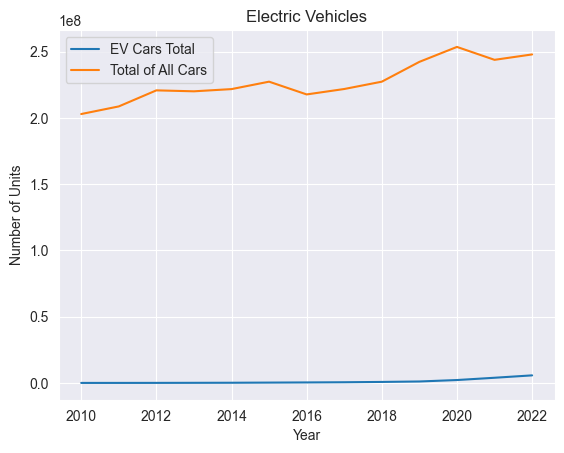

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(allEVCars, columns =['Year', 'EVCars'])
sorted_df_cars = df.sort_values('Year').reindex()
#print(sorted_df_cars)

df1 = pd.DataFrame(allEVCarsPercentage, columns =['Year', 'EVCarsPercentage'])
sorted_df_all = df1.sort_values('Year').reindex()
#print(sorted_df_all)

df_combined = pd.merge(sorted_df_cars, sorted_df_all, on='Year')

# using apply function to create a new column
df_combined['AllCars_Total'] = df_combined.apply(lambda row: 100*row.EVCars/row.EVCarsPercentage, axis = 1)

print(df_combined)

plt.plot(df_combined['Year'], df_combined['EVCars'], label = 'EV Cars Total')
plt.plot(df_combined['Year'], df_combined['AllCars_Total'], label = 'Total of All Cars')
plt.title("Electric Vehicles")
plt.xlabel('Year')
plt.ylabel('Number of Units')
plt.legend()
#plt.ylim(0, df_combined.max().iloc[2] + 1000000)
plt.show()

